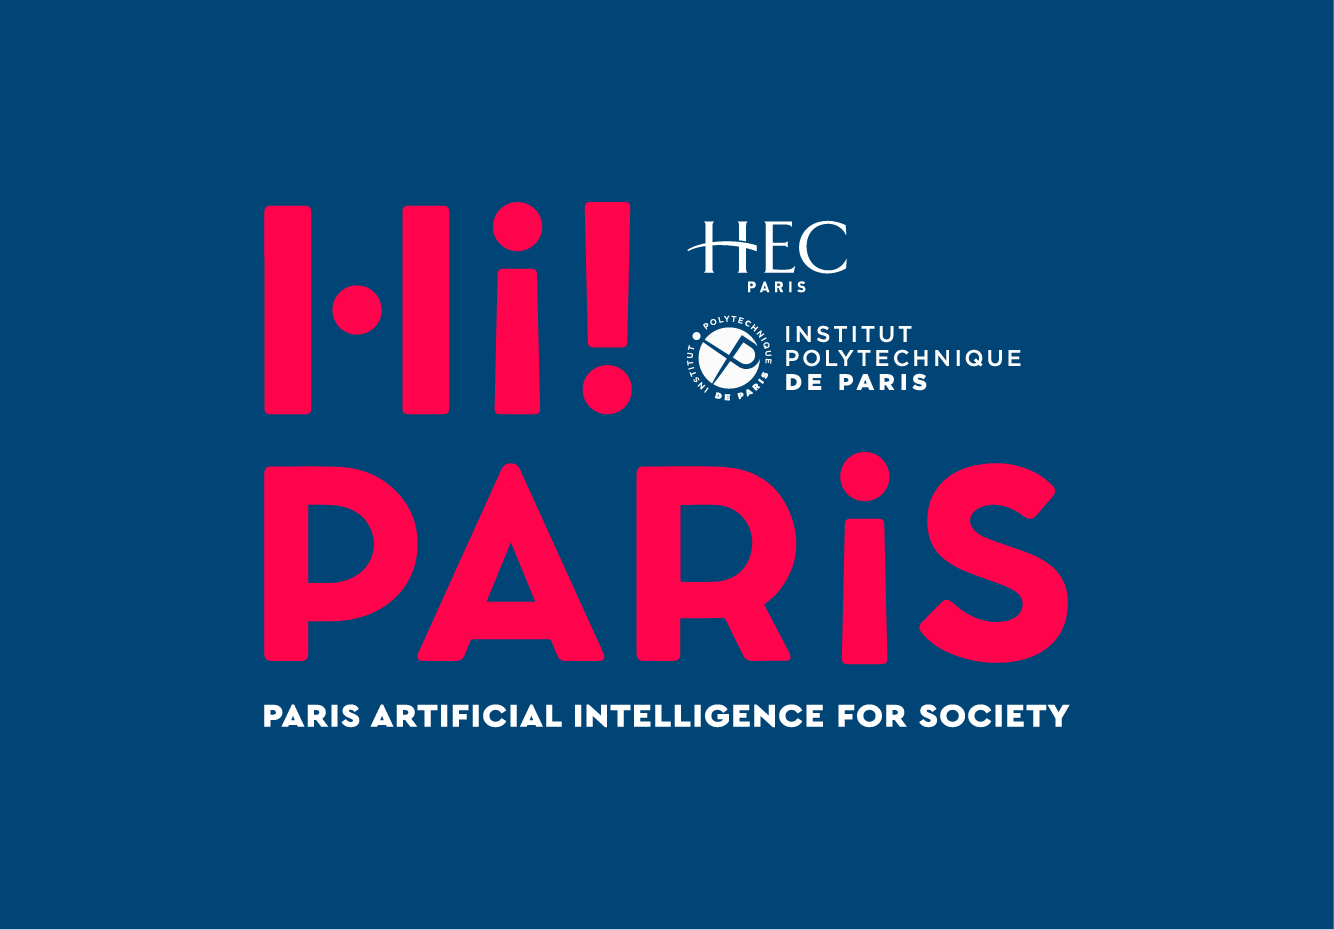

In [1]:
from IPython import display
display.Image("../../src/figures/Hi!PARIS_logo_bleu.png")

<br>
<body>
    <center><img src="../src/figures/Hi!PARIS_logo_bleu.png" style="width:50%;height:auto"></center>
    <p style="font-size:50px;text-align:center; color:#004475"><b><span style="color: #e61853">Hi!</span>ckathon 3</b></p><br>
    <p style="font-size:35px;text-align:center; color:#004475">Week 2 
    <p style="font-size:35px;text-align:center; color:#004475"> Models & Metrics </p><br>
    <p style="font-size:25px;text-align:center; color:#004475">Estimated duration : 2h</p><br>
    <br><p style="font-size:15px;text-align:left; color:#004475"><b>Authors : Haddam Yacine, Ka Alioune, Renaud Adrien, Vizy Jean Nicolas and Calot Baptiste </b></p><br>
</body>
<br>

In this lab we will look at two machine learning problems, regression which we started to discuss last week and classification. We will see the metrics specific to each of these problems and different machine learning models that can be used

## What is a machine learning model:

A machine learning model can be expressed as a link function $Y=f(X) + \epsilon$ which is most often the
result of error minimization : <p style="text-align: center;">$\sum_i E(Y_i - f(X_i))$</p> where
$(X_i,Y_i)$ is a list of pairs (features, target).

**Objective:** 
- Train the model from a dataset and assess its ability to generalize on unseen data
- Understand the explanatory factors of our target
    
**Method:**
- Separate the target variable from the features
- Separate the data into three samples (train / validation / test)
- Train the model (on the train set) and evaluate its performance (on the test set).

## Libraries & data imports

`data_dir` is the path to data folder.

In [1]:
data_dir = "../../data"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install xgboost

import os
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src/notebooks')
from utils.get_data import load_data
from utils.utils_model import plot_importance, plot_max_depth_influence, plot_n_estimators_influence, plot_alpha_influence_Lasso
import random

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import (
    mean_squared_error,
    max_error,
    mean_absolute_error,
    mean_squared_log_error,
    mean_absolute_percentage_error
)

from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.datasets import fetch_covtype
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

pd.set_option('display.max_columns', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 13.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
random.seed(42)

## Regression tasks

A regression task consists in predicting a continuous, numerical variable based on a number of features. More precisely, we will try to predict the `meter_reading` variable, plot the importance of the features of the database, and evaluate with metrics on train and test.

### Load data

We will use data we prepared during the course 1 (notebook 3), with dummisation and scaling

In [5]:
train = pd.read_feather(os.path.join(data_dir, 'model/train.feather'))
val = pd.read_feather(os.path.join(data_dir, 'model/val.feather'))
test = pd.read_feather(os.path.join(data_dir, 'model/test.feather'))

In [6]:
features = [
    # 'building_id',
    'lat',
    'lng',
    'square_feet',
    'air_temperature',
    'dew_temperature',
    'precip_depth_1_hr',
    'wind_speed',
    'sea_level_pressure',
    'wind_direction',
    'hour',
    'weekday',
    'month',
    'meter_name_chilledwater',
    'meter_name_electricity',
    'meter_name_hotwater',
    'meter_name_steam',
    'primary_use_Education',
    'primary_use_Entertainment/public assembly',
    'primary_use_Healthcare',
    'primary_use_Industry',
    'primary_use_Lodging/residential',
    'primary_use_Office',
    'primary_use_Other',
    'primary_use_Parking',
    'primary_use_Public services',
    'primary_use_Services',
    'zone_geo_EUROPE',
    'zone_geo_US',
    'site_id_0',
    'site_id_1',
    'site_id_2',
    'site_id_3',
    'site_id_4',
    'site_id_5',
    'site_id_6',
    'site_id_7',
    'site_id_9',
    'site_id_11',
    'site_id_12',
    'site_id_13',
    'site_id_15',
]

target = "meter_reading"

In [7]:
train_features = train[features]
val_features = val[features]
test_features = test[features]

In [8]:
train_target = train[target]
val_target = val[target]
test_target = test[target]

In [9]:
scal = StandardScaler()
# We fit on the train
scal.fit(train_features) 
train_features = pd.DataFrame(scal.transform(train_features), columns= train_features.columns)
# We apply the transformation on the validation and test set
val_features = pd.DataFrame(scal.transform(val_features), columns = val_features.columns)
test_features = pd.DataFrame(scal.transform(test_features), columns = test_features.columns)

### Evaluation metrics for a regression problem

 In this lab, as we are interested in a regression problem, we will first see some classic regression metrics.

Suppose we evaluate these metrics for a set $(y_i, \hat{y}_i)_{i=1,...n_{\text{test}}}$, where $y_i$ is the true value and   $\hat{y_i}$ is the prediction.


- **mean absolute error**:   
$\text{MAE} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} |y_i - \hat{y_i}|$ .


- **mean squared error**:   
$\text{MSE} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} (y_i - \hat{y_i})^2$, which is the most frequently used metric.


- **mean absolute percentage errors**: 
$\text{MAPE} = \frac{1}{n_{\text{test}}} \sum_{i=1,...n_{\text{test}}} \frac{|y_i - \hat{y_i}|}{y_i}$ .



MSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5.

From an interpretation standpoint, MAE is clearly the winner. MSE does not describe average error alone and has other implications that are more difficult to tease out and understand. The Mape give the mean of the average error.



In [11]:
def print_errors(model, X, y):
    y_pred = model.predict(X)
    print(f'MSE : {mean_squared_error(y, y_pred):.0f}')
    print(f'MAE : {mean_absolute_error(y, y_pred):.0f}')

### Linear Model

Linear Regression model fits a linear model with coefficients $\beta = (\beta_1,\beta_2, ..., \beta_m)  $  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form: $ \underset{\beta}{min}\sum_{i=1}^n {(y_{i}-X_{i}\beta)^2}$. The parameter $\hat\beta$ which solves this equation is the least square estimator.

In [12]:
reg = linear_model.LinearRegression()
reg = reg.fit(train_features, train_target)

Let's plot the coefficients of the model, in order to get a sense of the importances of the features:

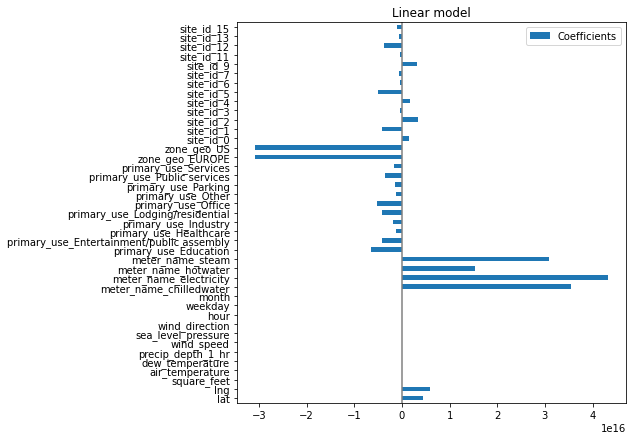

In [13]:
coefs = pd.DataFrame(
   reg.coef_,
   columns=['Coefficients'], index=train_features.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [15]:
print_errors(reg, test_features, test_target)

MSE : 33494052
MAE : 745


### Regression trees

Let us now turn our attention to regression trees and random forests, for our regression problem. They are among the simplest models in machine learning, but remain important because they are one of the few models that remain explainable: it is the opposite of the black box model.

A regression tree is a set of ordered decision rules, as in the figure below. There are many types of decision trees, but in machine learning they often take the form of binary trees. By going through the tree, we go through a succession of questions on the variables of the database, until ending up on a sheet, which allows us to know which output to assign to a given input.

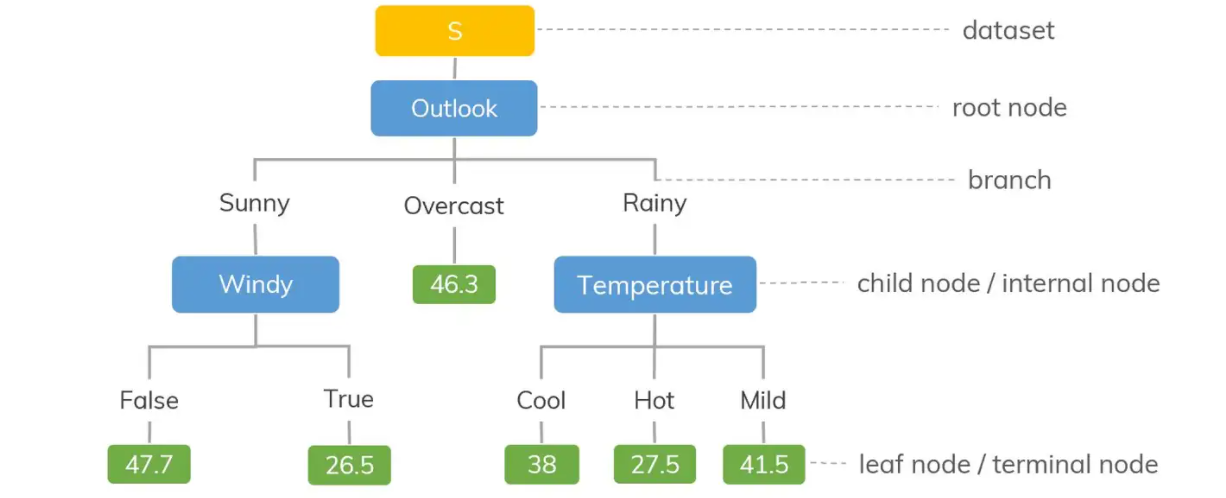

In [4]:
#<img src="../../src/figures/arbre_1.png" width=700 height=400 />
display.Image("../../src/figures/arbre_1.png")

At this stage, we can ask the following question: a given tree is easy to read, but on what bases, on what rules was it built? A classic tree-building algorithm is the CART (Classification and Regression Trees) algorithm.

To formalize a little, we can say that in this algorithm, we suppose that the tree divides the input space into M regions $ R_1, ..., R_M $. The value assigned in output for an input x can be represented in the form of a decision function f such as:

<p style = "text-align: center;"> $f (x) = \sum_{m = 1, ..., M} c_m \times \mathbb {I} \left (x \in R_m \right) $ </p>
 
Where the $ c_m $ are constants to be determined during training.

$\textbf {When do we stop splitting our regions?}$ The depth of the tree is generally considered to be a hyperparameter to be optimized. The classical algorithms therefore split in a binary way until the size of the tree reaches this parameter (which will be called in the following
$ max \_depth $), then then do some pruning. Pruning consists of removing certain nodes from the tree, based on a cost-complexity function. [see here](https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77).


**PROS**

- direct translation of the tree into a rule base
- undifferentiated treatment of different types of predictor variables
- robust against outliers, solutions for missing data
- speed and ability to handle very large databases

**CONS**

- stability problem
- poorer performance in general compared to other methods

#### Fit

We fit a decision tree on the train set.

In [16]:
model_tree = tree.DecisionTreeRegressor(max_depth=3, random_state=0)
model_tree = model_tree.fit(train_features, train_target)

We can visualize the fitted decision tree.

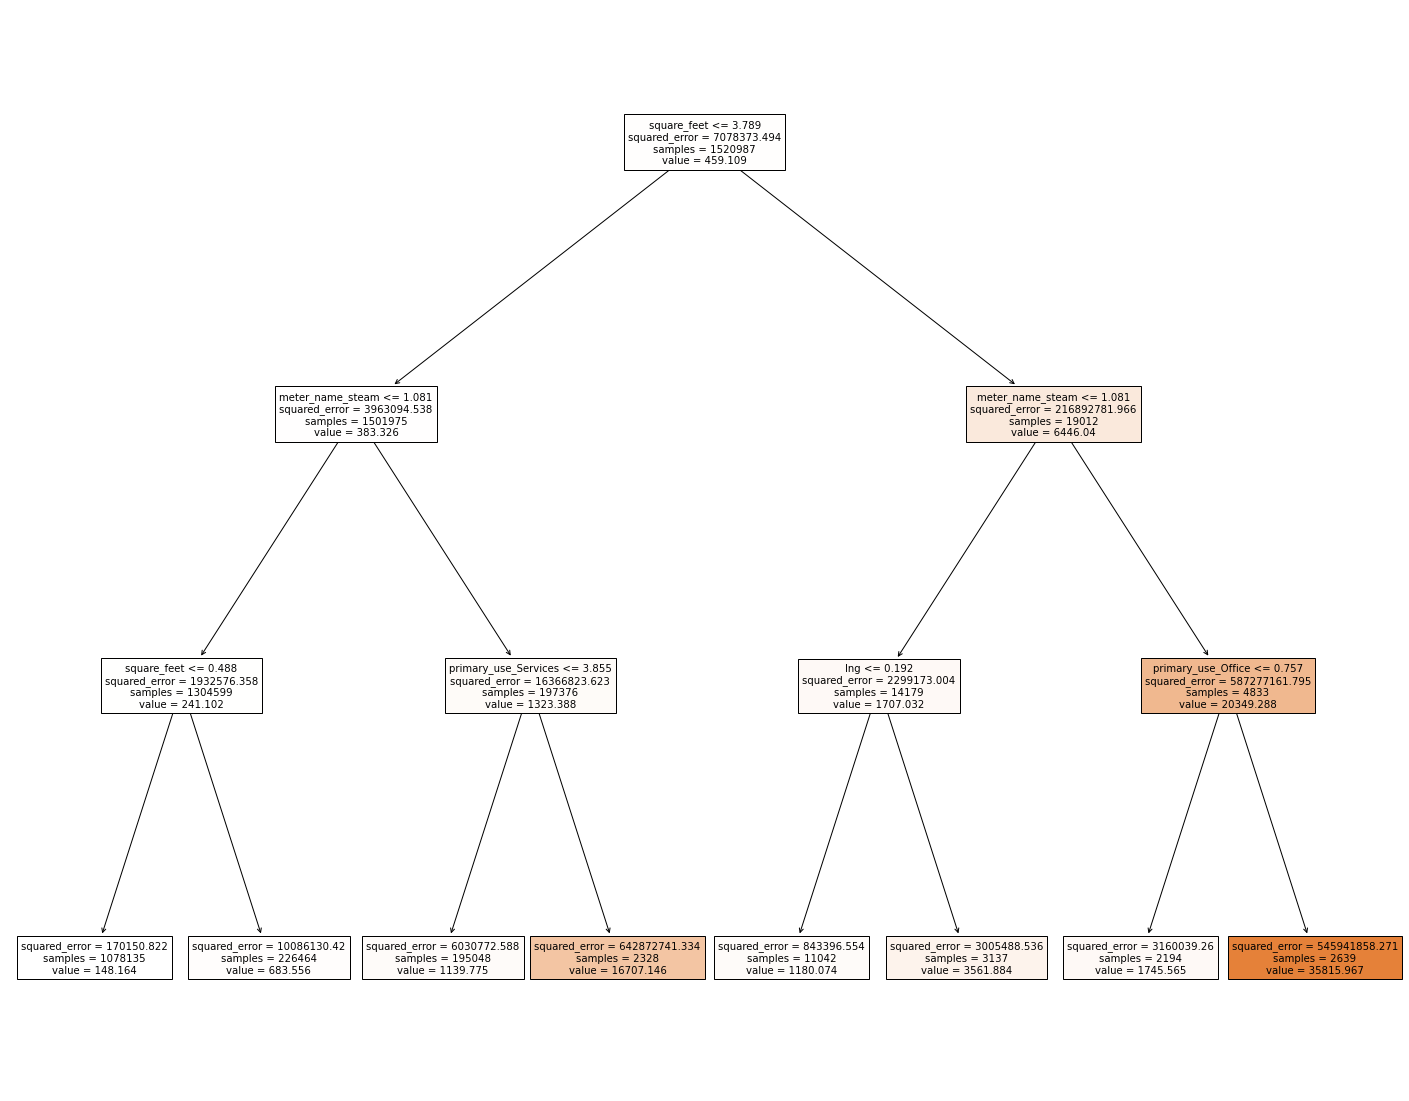

In [17]:
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(model_tree,
                   feature_names=train_features.columns,
                   filled=True)

#### Evaluation

Evaluate model performance on the validation set.  
For this we compute the MAE, MSE and maximum error.

In [18]:
print_errors(model_tree, val_features, val_target)

MSE : 2264394
MAE : 417


#### Feature importance

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

The scores are useful and can be used in a range of situations in a predictive modeling problem, such as:

- Better understanding a model.
- Reducing the number of input features.

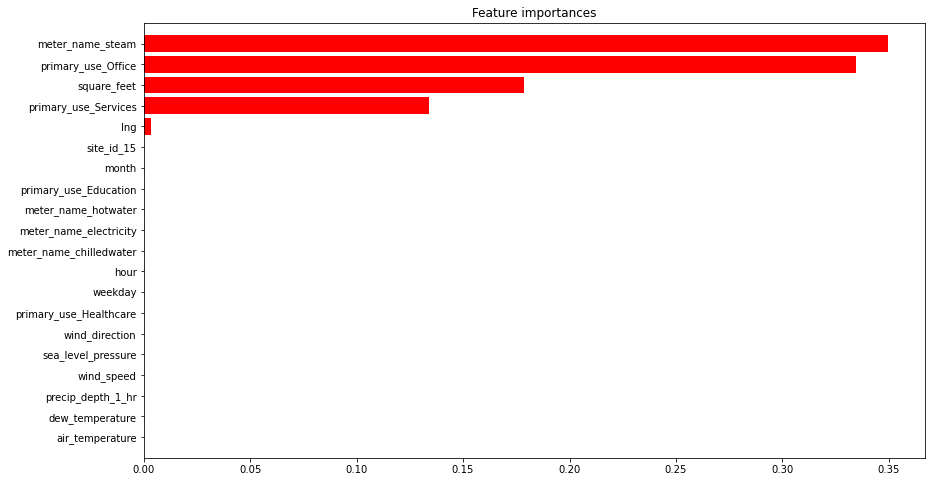

In [19]:
plot_importance(model_tree, train_features)

Fitting with max_depth = 2
Fitting with max_depth = 4
Fitting with max_depth = 8
Fitting with max_depth = 16
Fitting with max_depth = 32
Fitting with max_depth = 48


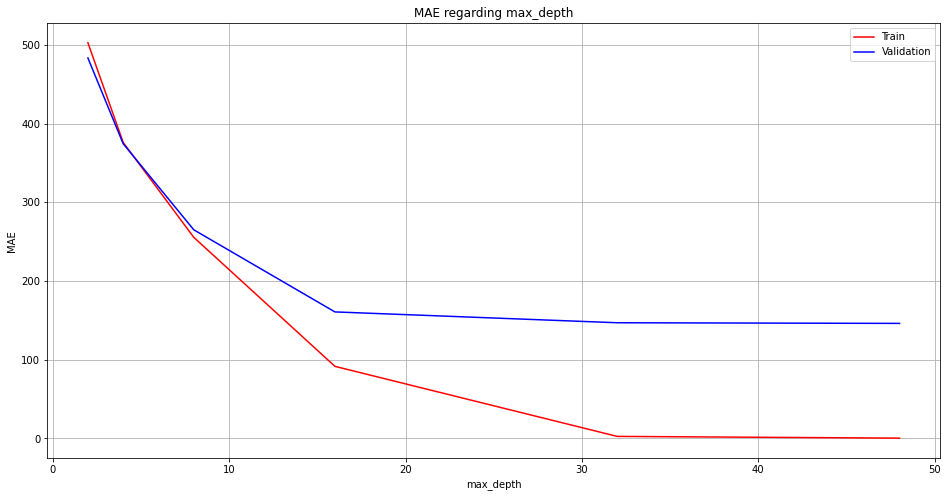

In [22]:
max_depth_ls = [2, 4, 8, 16, 32, 48]
plot_max_depth_influence(
    max_depth_ls,
    train_features, train_target,
    val_features, val_target,
)

### Random Forests

The main problem with decision trees is their large variance: a tiny error at the top of the tree is propagated all the way down the tree and it gets worse quickly. To stabilize the tree's predictions, we prefer to generate a set of trees, a forest and this algorithm is called *Random Forest*.


To create a random forest with B trees, we proceed as follows:

- For i ranging from 1 to B:
  - We draw randomly with replacement a sub-sample of the data size $ n <n _ {\ text {train}} $
  - We randomly draw a subsample of features of size m with in general $ m \leq \sqrt {p} $
  - On this new dataset composed of n examples and m features, we train a decision tree of fixed max depth
- We thus obtain $ B $ decision trees. If we denote by $ f1, ..., fB $ the prediction functions of each tree, then in regression, the decision function of the forest $ f_ {RF} $ will be:
<p style = "text-align: center;"> $ f_{RF} (x) = \frac{1}{B} \sum_{i = 1, ..., B} f_i (x)$ </p>

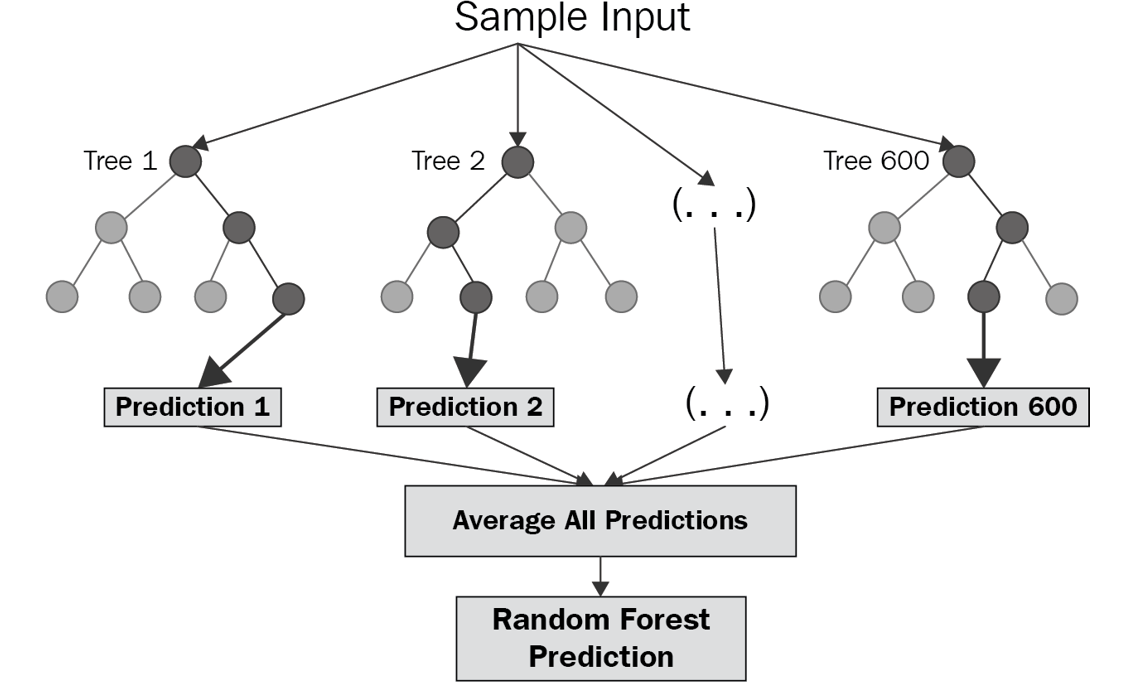

In [5]:
#<img src="../../src/figures/RF.png" width=900 height=500 />
display.Image("../../src/figures/RF.png")

#### The mains parameters

- *n_estimators* : number of trees in the foreset

- *max_features* : max number of features considered for splitting a node

- *max_depth* : max number of levels in each decision tree

#### Fit 

In [23]:
model_rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=16,
    random_state=0,
    n_jobs=-1
)
model_rf.fit(train_features, train_target)

RandomForestRegressor(max_depth=16, n_estimators=10, n_jobs=-1, random_state=0)

#### Evalution

Evaluate model performance on the validation set.  
For this we compute the MAE, MSE and maximum error.

In [24]:
print_errors(model_rf, val_features, val_target)

MSE : 1198637
MAE : 146


#### Plot importance

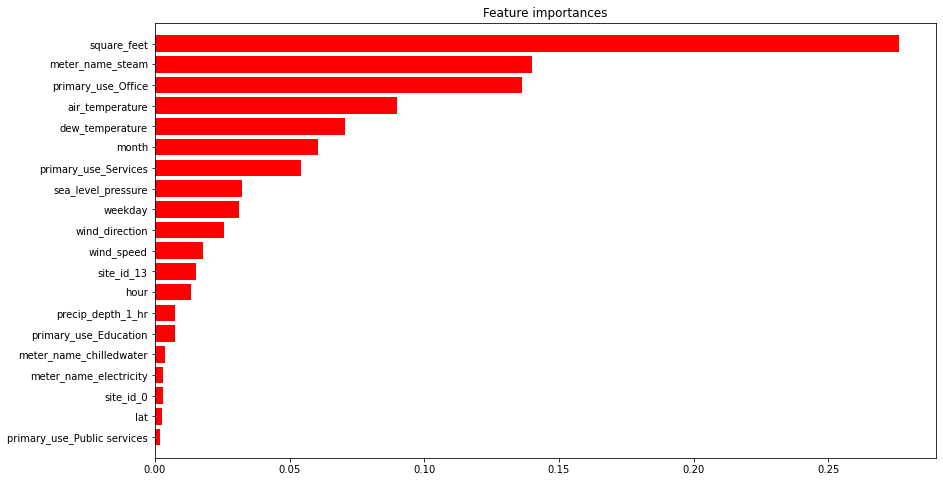

In [25]:
plot_importance(model_rf, train_features)

### Gradient Boosting

In gradient boosting algorithms, predictions are still made by a group of decision trees. However, trees are fitted sequentially, so that each new tree is designed to reduce the overall error as much as possible. For more details see the scikit-learn documentation (https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), or this paper (https://jerryfriedman.su.domains/ftp/stobst.pdf).

In [26]:
model_gb = GradientBoostingRegressor(
    n_estimators=10,
    max_depth=16,
    random_state=0
)
model_gb.fit(train_features, train_target)

GradientBoostingRegressor(max_depth=16, n_estimators=10, random_state=0)

In [27]:
print_errors(model_gb, val_features, val_target)

MSE : 1377137
MAE : 246


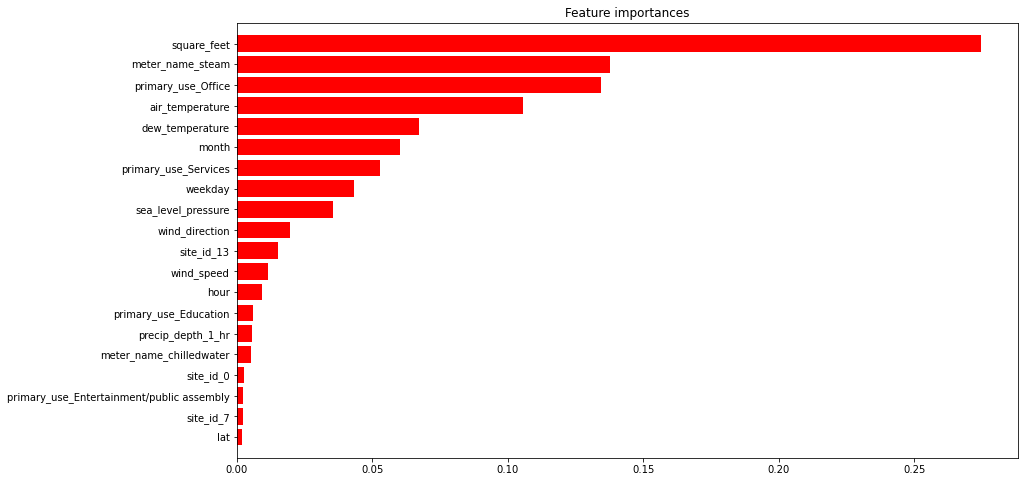

In [28]:
plot_importance(model_gb, train_features)

### XGBoost

In [29]:
model_xgb = XGBRegressor()
model_xgb.fit(train_features, train_target)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [30]:
print_errors(model_xgb, val_features, val_target)

MSE : 1227775
MAE : 186


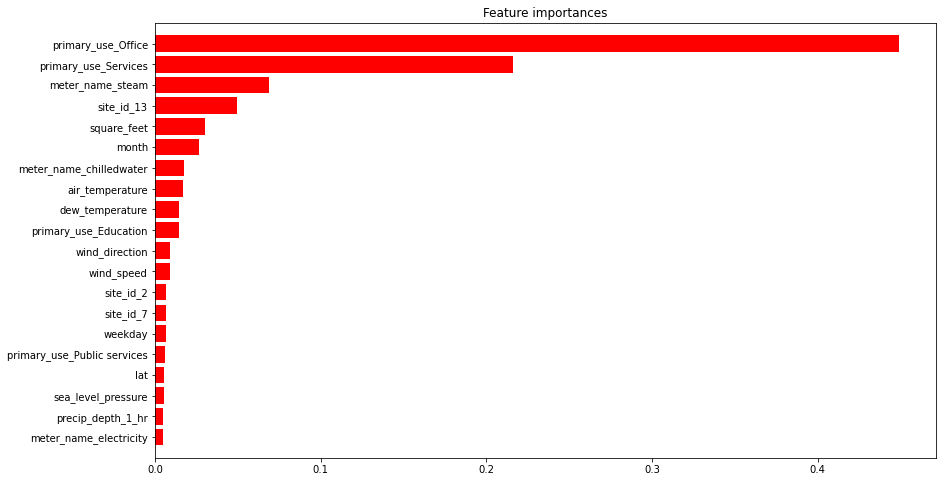

In [31]:
plot_importance(model_xgb, train_features)

### Multi-layer perceptron

Let's now focus on a category of (simple) neural networks, and how they can be used for regreesion tasks. In the following section, let us denote:
- **x** = $(x_1, x_2, ..., x_n)$ : the feature matrix
- **y** : the labels

**The computational model of a neuron**

A neuron is a bloc of mathematical operations linking entities, which can be summarized as follows:

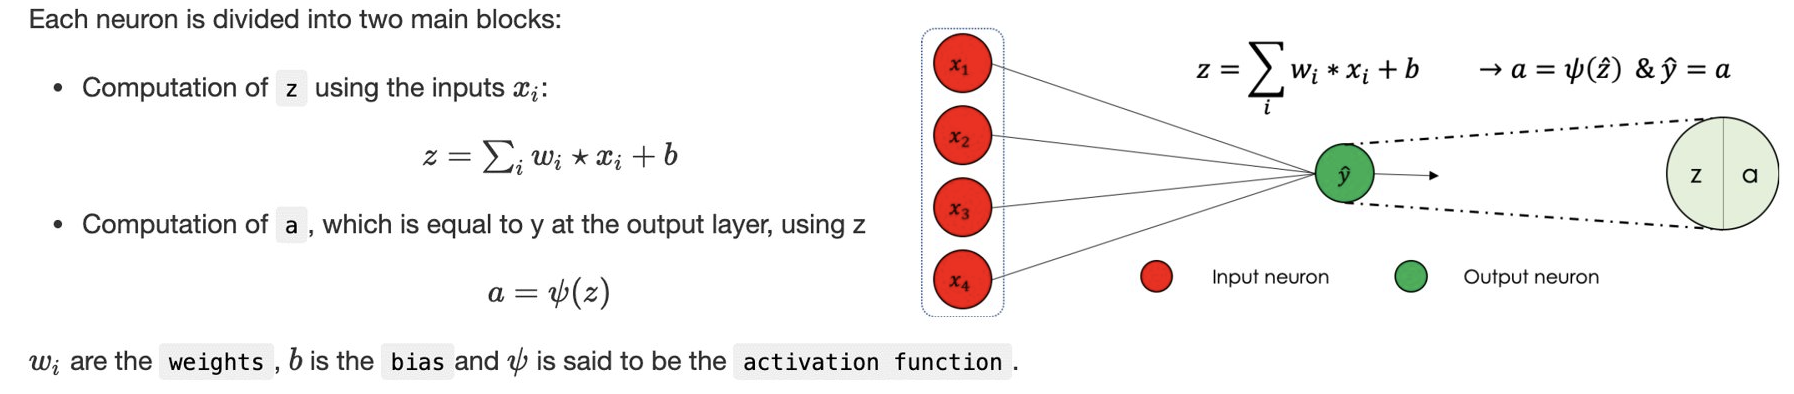

In [6]:
#<img src="../../src/figures/single_neuron_model.png" width=1200 height=1000 />
display.Image("../../src/figures/single_neuron_model.png")

We will talk again in session 5 about the role of the activation function, but please not that in the case where this function is the identity function ($f(x)=x$), the whole neuron becomes extremely similar to a simple linear model...

Another possible activation function for regression tasks is ReLu: $u \rightarrow max(0,u)$

**From neurons to neural networks**

A neural network is a combination of neurons, whose outputs are transformed via the identity or ReLu functions. Neural networks are essentially collections of simple, linear models, connected by linear or nonlinear activation functions, in order to generate new features from the input data, and learn complex, nonlinear decision rules.

**The multilayer perceptron for regression tasks:**

One of the simplest neural architectures is the multilayer perceptron, which can be summarized as follows:

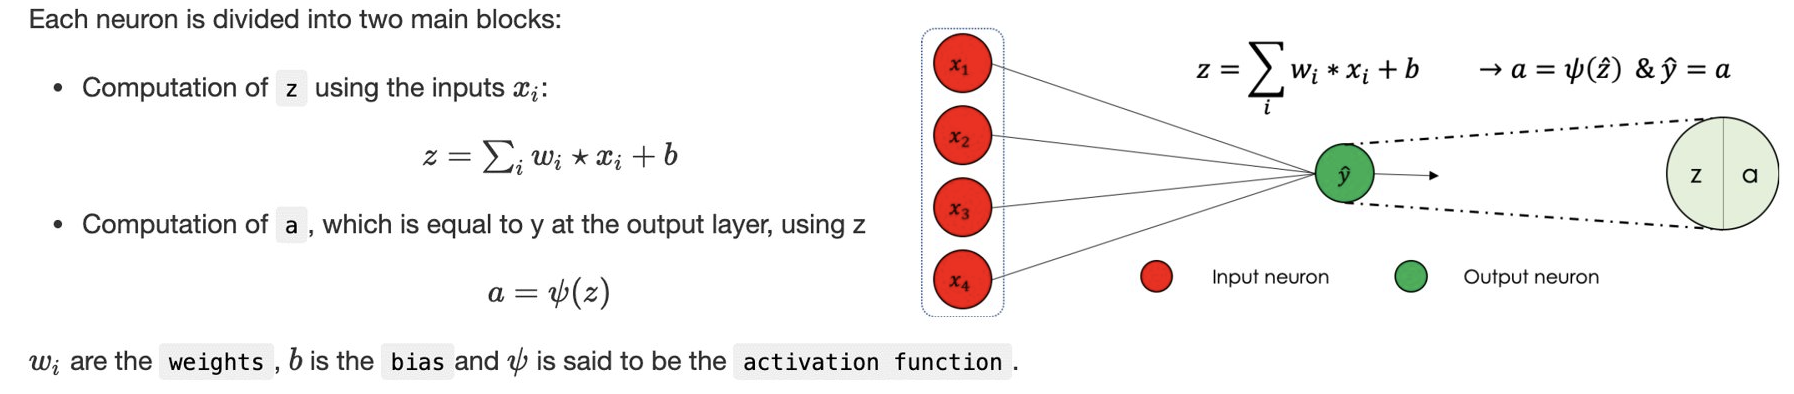

In [7]:
#<img src="../../src/figures/regression_mlp.png" width=500 height=500 />
display.Image("../../src/figures/single_neuron_model.png")

To be more precise:
- one input layer (whose dimension is equal to the number of features)
- one or several hidden layers, with a variable number of neurons
- a final layer, made of a single, fully connected neuron, which predicts the final output value.

Please also note that, in multi-layer perceptron mondels used for regression, activation functions are usually ReLu or identity (and in any case the final neuron MUST use one of these functions, because otherwise the model won't be suited for regression).

Here is a simple example of MLP, implement in the scikit-learn library (we will also see examples of neural networks built in libraries dedicated to deep learning in session 5):

In [32]:
model_mlp = MLPRegressor(hidden_layer_sizes = (100), 
                         max_iter = 20, 
                         activation = 'relu', 
                         random_state = 0,
                        verbose=True)

In [33]:
model_mlp.fit(train_features, train_target)

Iteration 1, loss = 3133668.97150433
Iteration 2, loss = 2864220.01494943
Iteration 3, loss = 2750525.38610318
Iteration 4, loss = 2649213.87156060
Iteration 5, loss = 2556640.23702328
Iteration 6, loss = 2473828.73770969
Iteration 7, loss = 2398032.19120044
Iteration 8, loss = 2332436.03641410
Iteration 9, loss = 2275947.96532415
Iteration 10, loss = 2231584.59082386
Iteration 11, loss = 2194222.12161569
Iteration 12, loss = 2162511.18849419
Iteration 13, loss = 2136218.99169266
Iteration 14, loss = 2113859.93170245
Iteration 15, loss = 2095227.68842772
Iteration 16, loss = 2078872.00156860
Iteration 17, loss = 2065946.62710451
Iteration 18, loss = 2055070.52890657
Iteration 19, loss = 2045768.71288931
Iteration 20, loss = 2037231.53425416


MLPRegressor(hidden_layer_sizes=100, max_iter=20, random_state=0, verbose=True)

In [34]:
print_errors(model_mlp, val_features, val_target)

MSE : 2119241
MAE : 318


### Stacking of models

Model stacking is based on a simple idea: instead of using trivial functions (such as the mean) to aggregate the predictions of all predictors in a set in the case of a random forest for instance, why not train a model to perform this aggregation?

Let' assume that we have B differents models represented by $\hat M_1,\hat M_2, \hat M_3,... \hat M_B $.

- We divide $X_{train}$ in two parts : $(X_{train_1}, X_{train_2})$.


- We train $\hat M_1,\hat M_2, \hat M_3,... \hat M_B $ on $X_{train_{1}}$.


- We make B differents predictions on $X_{train_2}$ : $ \hat y_1 , \hat y_2, ..., \hat y_B$

If we denote $\hat X =  (\hat y_1 , \hat y_2, ..., \hat y_B)$

- Then we train a last model $\hat M_L$ on $(y_{train_2} , \hat X )$ 


Finally several models are trained on the data and a last model is trained on the predictions of the other models. This is a new training set!

This last model is called a meta model and we can choose the one we want. 


We will choose a linear model because we find that it makes sense to model the predictions of the others with a linear model; however it's not necessarily the best choice.

All of these models have been trained in the past :

In [35]:
estimators = [('rf', model_rf),('gdb', model_gb),('xgb',model_xgb),('dtr', model_tree),('mlp',model_mlp)]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=linear_model.LinearRegression(), 
    cv = 'prefit' )

In [36]:
reg.fit(train_features, train_target)

StackingRegressor(cv='prefit',
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=16,
                                                     n_estimators=10, n_jobs=-1,
                                                     random_state=0)),
                              ('gdb',
                               GradientBoostingRegressor(max_depth=16,
                                                         n_estimators=10,
                                                         random_state=0)),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_round...
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...)),
                              ('dtr',
                               DecisionTreeRegressor(max_depth=3,
                                                     random_state=0)),
                              ('mlp',
                               MLPRegressor(hidden_layer_sizes=100, max_iter=20,
                                            random_state=0, verbose=True))],
                  final_estimator=LinearRegression())

NB : the stacking regressor function split the train set into 2 train subset

In [37]:
print_errors(reg, val_features, val_target)

MSE : 1430554
MAE : 144


## Classification tasks

In this section, we're going to present several algorithm families that are suited for classification tasks. Contrary to regression tasks, where we try to predict a numerical, continuous variable, in classification we try to predict a categorical, discrete variable.

Classification tasks can either be:
- binary (e.g. predict whether a payment is fraudulent or not): the output of prediction can then be represented as a boolean (True or False), or, more commonly, as a binary value (1 or 0)
- multilabel (e.g. a data point can belong to one category among several): the output of a prediction will be the label of the category that the model finds most relevant to the data point, or a vector of conditional probabilities (i.e the probability that the data point belongs to category 1, category 2, ..., category n).

### Classification metrics

Here is a quick summary of the most common classification metrics:

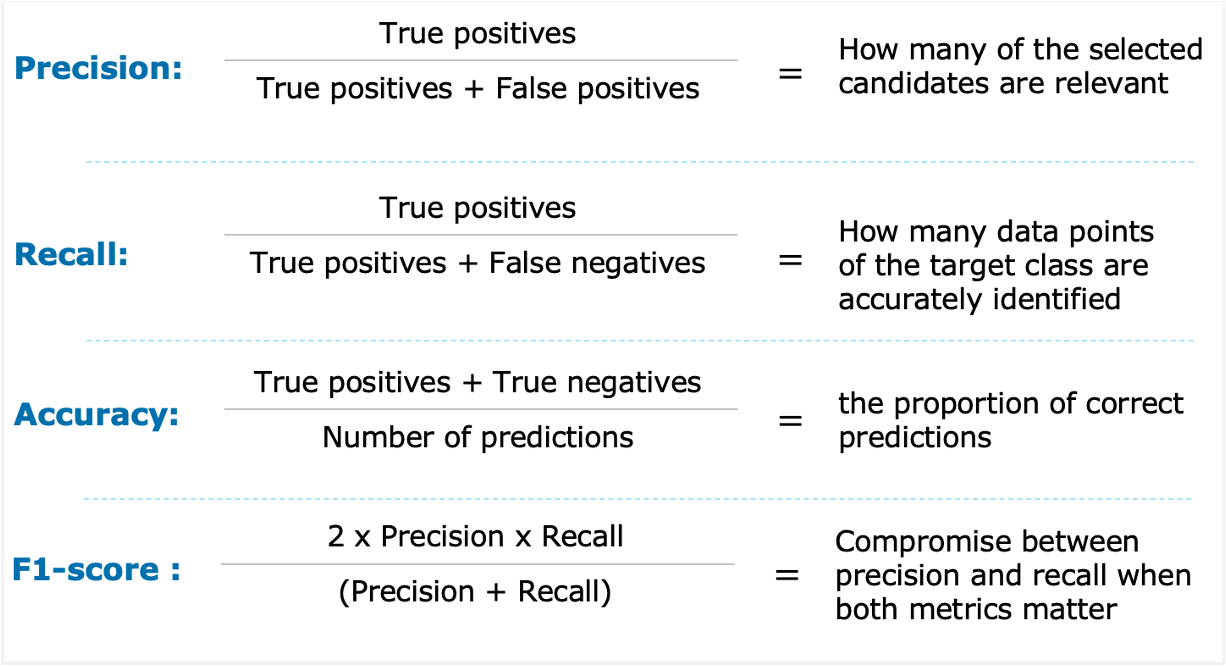

In [8]:
#Image.open("../../src/figures/classification_metrics2.png").resize((600,400))
display.Image("../../src/figures/classification_metrics2.png",height=900,width=700)

Each of these metrics attempts to answer a specific question:
- accuracy: what percentage of my predictions are correct?
- precision: if I focus on a given class (say, fraudulent payments): what percentage of predicted frauds are actual frauds?
- recall: if I focus on a given class (say, fraudulent payments): what percentage of the actual frauds can I correctly identify with my model?
- f1-score has no simple direct interpretation, but it's a handy measure when you want to monitor both precision and recall and summarize them in a single metric.

Please also note that, in the case of multiclass classification, precision, recall, and f1-score can be calculated for each class, and then averaged over all classes in order to provide a synthetic view of the model performance.

### Prepare data

First, we're going to download a new dataset:

In [38]:
data, target = fetch_covtype(return_X_y=True,as_frame=True)

The dataset consists of a summary of the geographical and geological characteristics of 580,000 forests. The goal is to predict the cover type (i.e. the dominant tree species) of a forest, based on these attributes. Please note that the categorical features are already one-hot-encoded, so there's no need to do that again.

In [39]:
data.shape

(581012, 54)

In [40]:
data.head(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Each cover type is identified by a number :

In [41]:
sorted(target.unique())

[1, 2, 3, 4, 5, 6, 7]

Now, let's split this dataset in a training and a  validation set:

In [42]:
Xtrain, Xval, Ytrain, Yval = train_test_split(data, target, test_size=0.2, stratify=target)

Please note that in defining the training and validation sets, we have passed "target" as an argument for the "stratify" parameter. This will force the training and validation sets to have approximately the same proportions of each cover type, and avoid generalization problems due to selection biases.

We can now test a variety of classification models (or "classifiers") on this data. We will use scikit-learn's classification report to derive the key metrics for each set of predictions.

### Logistic regression

Despite its name, logistic regression is used for classification purposes, rather than regression. However, it is somewhat similar to linear regression in the sense that it tries to predict the probability of a given point to belong to a class as a function of a linear combination of the point's features : 

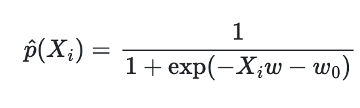

In [9]:
display.Image("../../src/figures/equation_regression_logistique.png",height=250,width=250)

Where:

- $\hat p(X_i)$ denotes the probability of point $ X_i$ to belong to a given class
- $w = w_1, ... w_p $ denotes the weight vector of the p features of the model (analog to $\beta$ in linear regression models)
- $w_0$ is an intercept (scalar), as in a linear regression model

Please note that the transform $u \rightarrow \Large\frac{1}{1+exp(u)}$ is meant to convert the linear combination of the features ($\sum_{k}^{} x_k.w_k\ + w_0$), which can take any real value, in a probability (comprised between 0 and 1).

In [43]:
clf = LogisticRegression()
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xval)
print(classification_report(Yval, Ypred))

              precision    recall  f1-score   support

           1       0.62      0.64      0.63     42368
           2       0.63      0.77      0.69     56661
           3       0.61      0.23      0.34      7151
           4       0.00      0.00      0.00       549
           5       0.00      0.00      0.00      1899
           6       0.20      0.00      0.01      3473
           7       0.05      0.00      0.00      4102

    accuracy                           0.62    116203
   macro avg       0.30      0.23      0.24    116203
weighted avg       0.58      0.62      0.59    116203



**Interpreting classification results:**


The classification report reads as follows:
> - class 1 has a precision of 0.62 (meaning that on average the model is right 62% of the time when it predicts cover type 1)
> - class 1 has a recall of 0.65 (meaning that on average the model correctly identifies 64% of the forests whose actual cover type is 1
> - class 1 has an f1-score of 0.63
> - class 1 is represented by 42,368 data points in the test set (out of a total of 116,203 data points).

The same metrics are provided for the other classes as well. The bottom part of the chart summarizes aggregate statistics:
> - the overall accuracy is 0.62, meaning that 62% of all predictions are correct
> - the weighted average precision is 0.58, meaning that the average of the class precisions, weighted by their proportion in the test set, is 0.58
> - the same applies for the weighted recall and f1-score

However, the 'macro avg' line provides lower figures:
> - the 'macro avg' metrics are unweighted class metrics, e.g. the sum of all class precisions, divided by the number of classes
> - the macro-averaged metrics are much lower than the weighted metrics, because some classes are very poorly identified by the classifier

As we can see, classes 4 through 7, which have much fewer examples in the test set than classes 1 to 3, are almost ignored by the model!

**What can we learn from this example?**
> - Assessing a classification algorithm may require to take multiple metrics into account
> - In particular, the way minority classes are handled can have critical importance
> - This is especially true when you try to predict rare events (e.g. frauds in the payments industry, or cancer diagnostics)
> - **As a result, plain accuracy (i.e. the proportion of correct predictions) is often a poor measure of the performance of a classifier**

**What can I do if my classifier struggles with some minority classes?**
> - If these classes do not have a significant practical impact, you might consider skipping them altogether
> - If they do matter, choose classification metrics that focus on these classes, or at least take them into account (e.g. macro-averaged precision, recall etc.)
> - If you want to increase your classifier's performances, consider using a better model, or adding more examples of the minority classes, if you can find some, or generate them.

As we can see, the logistic regression fails to accurately predict minority cover types. In the next sections, we will try to find better classifiers.

### Linear discriminant analysis

In the linear (or quadratic) discriminant analysis, the features of each class are assumed to follow a gaussian multivariate distribution. For each class, the mean vector and the covariance matrix are determined using the maximum likelihood principle. Finally, predictions are made based on the distance of each new point to the mean of each classes: the closer it is to a given class mean, the higher the probability that it will belong to it.

Visually, this can be summarized as follows:

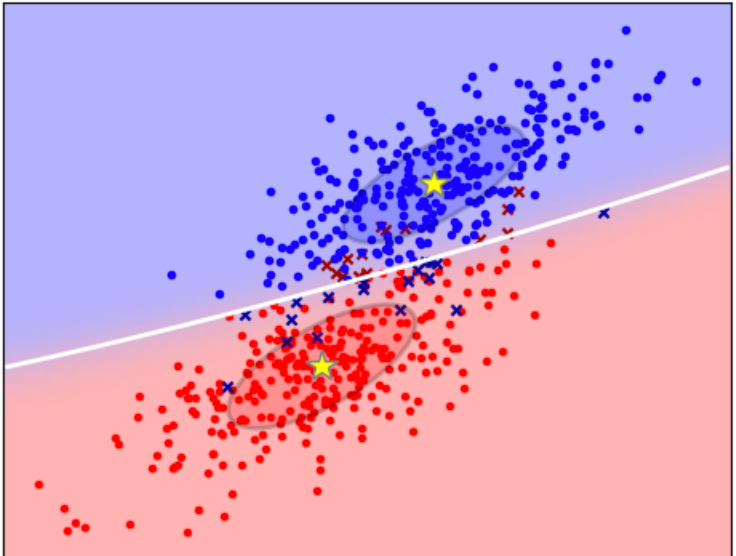

In [10]:
display.Image("../../src/figures/lda_qda.png",height=500,width=500)

On this chart, actual labels are represented by the color of the points, correct predictions are represented by dots, and wrong predictions by crosses. Labels are predicted based on the proximity to the class means (represented by the stars).

Please note that, in linear discriminant analysis, covariance matrices are assumed to be identical across all classes, while in quadratic discriminant analysis, they are assumed to be different.

In [44]:
clf = LinearDiscriminantAnalysis()
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xval)
print(classification_report(Yval, Ypred))

              precision    recall  f1-score   support

           1       0.70      0.62      0.66     42368
           2       0.75      0.76      0.76     56661
           3       0.62      0.54      0.58      7151
           4       0.26      0.56      0.35       549
           5       0.29      0.21      0.25      1899
           6       0.34      0.51      0.41      3473
           7       0.41      0.80      0.54      4102

    accuracy                           0.68    116203
   macro avg       0.48      0.57      0.51    116203
weighted avg       0.69      0.68      0.68    116203



As we can see, the macro-averaged metrics have improved a lot with respect to the previous model: the macro-averaged precision has increased from 0.28 to 0.49, and the macro-averaged recall has jumped from 0.23 to 0.58. However, there is still room for improvement. In order to identify the most common errors this classifier makes, let's print its confusion matrix:

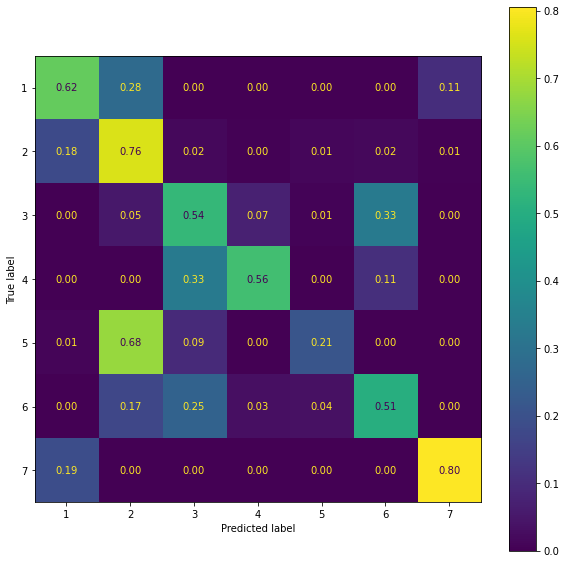

In [45]:
cm = confusion_matrix(Yval, Ypred, labels=sorted(target.unique()), normalize='true')
fig, ax = plt.subplots(figsize=(10,10))
cm_display = ConfusionMatrixDisplay(cm,display_labels=sorted(target.unique()))
cm_display.plot(cmap='viridis',values_format='.2f',ax=ax)

**Interpreting confusion matrix**
This matrix illustrates how some classes are incorrectly predicted. For instance, 28% of the samples of class 1 are mistaken for samples of class 2. This is annoying, class 1 and class 2 are the majority classes of this dataset, and the least we can expect from a classifier is to be able to predict them correctly. As a result, class 1 recall is relatively low (only 62%).

**What can I do do improve this?**
Several actions can be taken to better distinguish class 1 from class 2:
> - if distinguishing them is not so important from a practical point of view, why not merge them?
> - if it's not possible, can I add or build features to help the model separate them?
> - can I add more data to my training set ? (this could work for class 1, but it would be even more relevant for minority classes such as classes 3 to 7)
> - can I use a better model?

**Another option may consist in adjusting probability thresholds for class 1, in order to improve class 1 recall:**
Indeed, the classifier does not directly predict the class: rather its output is a probability vector, which indicates the probabilities of a given data point to belong to class 1, 2, ... 7. By default, a data point is assumed to belong to the class with the highest probability (in multiclass classification, such as in this example), or the class that has a probability higher than 0.5 (in binary classification, where the goal is to answer the question ('does this point belong to class 1? yes or no?').

However, we can set different rules based on the class probabilities. For instance, instead of predicting that a point belongs to class 1 if its class 1 probability is higher than 0.5, we can say that it belongs to class 1 if its class 1 probability is higher to 0.4 (if we want to increase the recall at the expense of precision), or if its probability is higher than 0.6 (if we want to increase the precision at the expense of the recall).

**Let's see how it works with an example:**
Let's see the class 1 probabilities obtained from the model

In [46]:
probas_class1 = pd.Series(clf.predict_proba(Xval)[:,0])#here we take the 1st column, which is indexed on '0', as every count in python starts at 0 by default

now, let's transform the actual labels in a binary vector (with values equal to 1 when the sample belongs to class 1, else 0):

In [47]:
is_class1 = Yval.apply(lambda x: 1 if x==1 else 0)

for a given probability threshold (e.g. 0.4), we can generate adjusted predictions:

In [48]:
threshold = 0.4
adjusted_predictions = probas_class1.apply(lambda x: (x>=threshold)*1)

now, we can compute the classification metrics for class 1, based on the new threshold:

In [49]:
print('class 1 precision with probability threshold set to {}: {}'.format(threshold, np.round(precision_score(is_class1,adjusted_predictions),2)))
print('class 1 recall with probability threshold set to {}: {}'.format(threshold, np.round(recall_score(is_class1,adjusted_predictions),2)))

class 1 precision with probability threshold set to 0.4: 0.67
class 1 recall with probability threshold set to 0.4: 0.68


As you can see, lowering the probability threshold has increased recall from 0.62 to 0.68, and slightly decreased the precision (from 0.7 to 0.67). If we want to find an optimal probability threshold (for instance, one that maximizes the f1-score), we can repete this process for a hundred different thresholds, and look at the curve metrics curve:

In [50]:
precisions = []
recalls = []
f1s = []

for threshold in np.arange(0,1,0.01):
    adjusted_predictions = probas_class1.apply(lambda x: (x>=threshold)*1)
    precisions.append(precision_score(is_class1, adjusted_predictions))
    recalls.append(recall_score(is_class1, adjusted_predictions))
    f1s.append(f1_score(is_class1, adjusted_predictions))


<AxesSubplot:xlabel='threshold'>

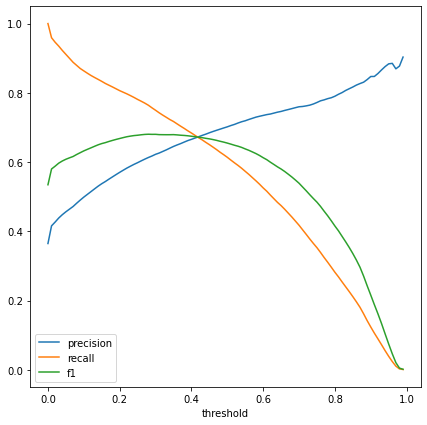

In [51]:
#fig, ax = plt.subplots(figsize=(10,10))
results = pd.DataFrame([list(np.arange(0,1,0.01)),precisions,recalls,f1s]).T
results = results.rename(columns={0:'threshold',1:"precision",2:"recall",3:"f1"}).set_index("threshold")
results.plot(figsize=(7,7))

Here we can see, for instance, that the f1-score for a threshold of 0.3 would be slightly higher than with a threshold of 0.5, so if a slight drop in precision isn't a problem, we can lower the threshold to 0.3, in order to correctly detect approximately 72% of all class 1 data points. 

### Classification trees

We've seen earlier that we can use decision trees to perform regression tasks. However, we can also use them in classification tasks.

**How can we adapt trees to classification tasks?**
Trees are built iteratively, by splitting the training data at each tree node, until the desired tree depth (or some other stopping criterion) is reached. Each split of the dataset is made in order to divide the parent subset of data into two smaller, more homogeneous subsets. The homogeneity of the resulting subsets is measured through an **impurity measure**: the higher the impurity, the more heterogeneous the children subsets will be. 

As a result, a new split is made by looking for the criterion that contributes more to decreasing the impurity.

**In practice, for a regression task:**
> - the obvious impurity measure is the variance of the target variable for the data points within each subset
> - when splitting the data, for each feature and each possible value of this feature, the algorithm will divide the data points in two groups (e.g. above vs below this value, or equal vs different from this value), and compute the variances for both groups
> - the criterion that best contributes to reducing the overall variance will be retained to split the data.

**For a classification task:**
> - The procedure is quite similar, except that we use different impurity measures, such as binary cross-entropy, or gini coefficient.

As a consequence, decision trees, and all tree-based models (random forests, gradient-boosting trees/ XGBoost) can be adapted to perform classification tasks. However, please note that, even if classification and regression trees are conceptually quite similar, they are implemented differently in the most popular data science libraries, as evidenced by the example below:

In [52]:
from sklearn.ensemble import RandomForestClassifier # please note that, in the regression example, the module was called 'DecisionTreeRegressor'

In [53]:
clf = RandomForestClassifier()
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xval)
print(classification_report(Yval, Ypred))

              precision    recall  f1-score   support

           1       0.97      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.85      0.88       549
           5       0.94      0.76      0.84      1899
           6       0.94      0.89      0.92      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.90      0.92    116203
weighted avg       0.95      0.95      0.95    116203



That's a huge improvement over the previous model! Can we go further, with more elaborate tree-based models?

### Multi-layer perceptrons for classification

Just as tree based models, multilayer perceptrons can also be adapted to classification tasks, if they are modified appropriately.

**The computational model of a neuron**

Let's first look at the basic block - the simple perceptron:

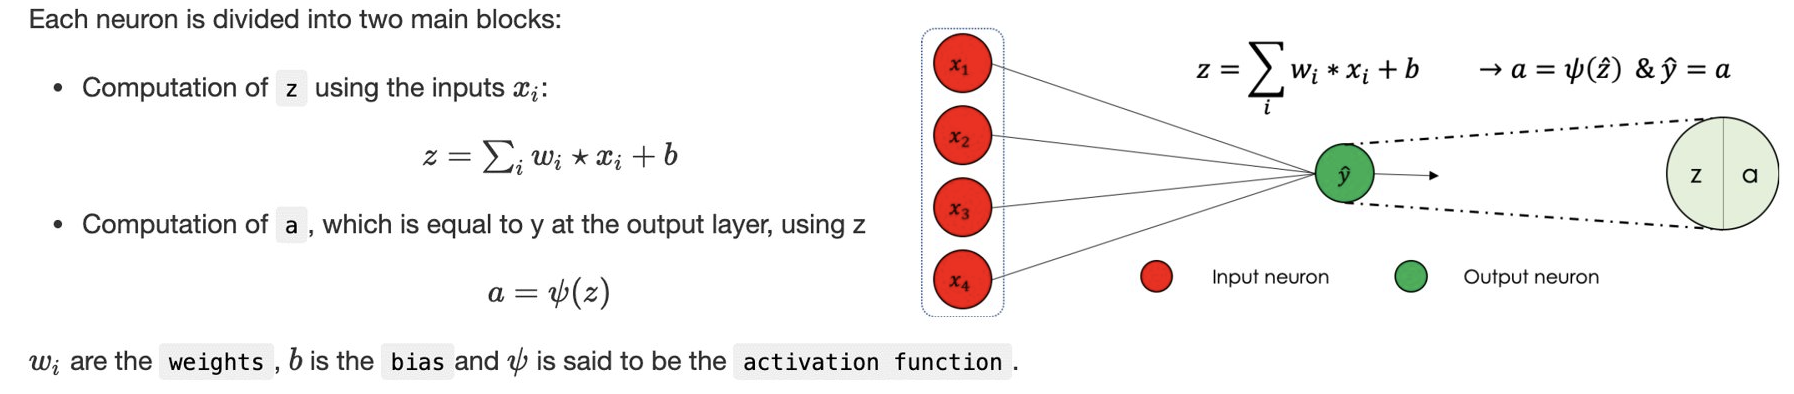

In [11]:
display.Image("../../src/figures/single_neuron_model.png",height=1200,width=1200)

It works exactly like a single neuron for a regression task, with one difference: the activation function $ \psi(z)$ is not the identity or the relu function, but one of the nonlinear activation functions described below. These functions play a similar role to the logistic function ($ u \rightarrow \Large\frac{1}{1+exp(u)}$) in the logistic regression model. Overall, a single neuron in a classification task is somewhat similar to a logistic regression model.

Activation functions for the output layer in classification tasks can be:
> - sigmoid: $u \rightarrow \Large\frac{\mathrm{1} }{\mathrm{1} + e^-u}$

> - tanh: $u \rightarrow \Large\frac{e^u-e^{-u}}{e^u+e^{-u}} $

> - softmax: $Softmax(\textbf{z})_i = \Large\frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}$ (for multiclass classification: represents the probability of a point to belong to class i, among k possible classes).


**From neurons to neural networks**

A multi-layer perceptron designed for classification tasks can be represented as follows:


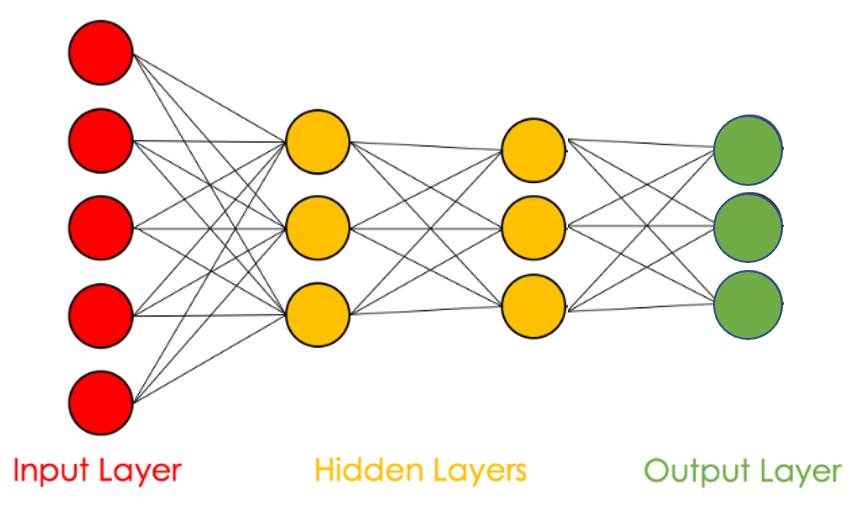

In [12]:
display.Image("../../src/figures/classification_mlp2.png",height=500,width=400)

The main differences compared to regression MLPs are the following:
- in multiclass classification, the number of neurons on the output layer must be equal to the number of predicted classes
- the activation function for the output layers isn't identity or ReLu, but nonlinear functions, such as sigmoid or softmax.

## To Do

### Feature importance

Based on the feature importance of the Regression tree, drop some insignificant features on *train* and fit a new model. Is your model better now ?

In [ ]:
# TODO 1

In [ ]:
to_drop = ["lat"]
target = "meter_reading"

model_rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=16,
    random_state=0,
    n_jobs=-1
)
model_rf.fit(train[features].drop(to_drop, axis=1), train[target])
print_errors(model_rf, val[features].drop(to_drop, axis=1), val[target])

### Feature engineering

Using your background, create a new feature who seems interesting (do it on train, val and test). What is the impact of this feature on your model ?

In [ ]:
# TODO 2

In [ ]:
train['is_weekend'] = np.where((train["weekday"] >= 0) & (train["weekday"] <= 4), 0, 1)
val['is_weekend'] = np.where((val["weekday"] >= 0) & (val["weekday"] <= 4), 0, 1)

model_rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=16,
    random_state=0,
    n_jobs=-1
)
model_rf.fit(train[features + ["is_weekend"]], train[target])
print_errors(model_rf, val[features + ["is_weekend"]], val[target])


### Model testing

Remember how regression tree-based models can be adapted to classification? Find the equivalent of XGBRegressor for classification in the XGBoost documentation (https://xgboost.readthedocs.io/en/stable/), and use it on the classification example covered in section 6. Don't forget to import modules if necessary. **Warning! If you receive an error message while fitting the model, please try to rename labels (1 in 0, 2 in 1, ... 7 in 6).**

In [ ]:
# TODO 3

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier()
Ytrain2 = Ytrain.apply(lambda x: x-1)
Yval2 = Yval.apply(lambda x: x-1)
clf.fit(Xtrain,Ytrain2)
Ypred = clf.predict(Xval)
print(classification_report(Yval2, Ypred))

### Classification MLP

Based on the code sample in 5.7 and the information provided in 6.6, try to adapt the MLP architecture for the classification task. Don't forget to import modules if necessary.

In [ ]:
# TODO 4

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (100), 
                         max_iter = 30, 
                         random_state = 0,
                         verbose=False)

mlp.fit(Xtrain, Ytrain)


Ypred = mlp.predict(Xval)
print(classification_report(Yval, Ypred))

## Go further!
- Hastie T., Tibshirani R., Friedman J., « [The elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) - Data Mining, Inference and Prediction », Springer, 2009.